In [2]:
import re
import nltk
import binascii
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# download stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

# load data
file = open('./Shingle_data/articles-1000.txt', 'r')

corpus = []
articleMap = {}


for row in file:
 
    # split corpus into list of words
    article = row.lower().split()
    
    # remove article ID
    articleID = article[0]
    del article[0]
    
    # remove stopwords
    article = list(filter(lambda x: x not in sw, article))
            
    # generate shingles and add to corpus
    shingles = list(nltk.bigrams(article))
    shingles = list(map(' '.join, shingles))
    corpus.append(shingles)
    
    # hash each shingle into a 32-bit integer
    shingleIDs = set(map(lambda x:binascii.crc32(bytes(x, 'UTF-8')) & 0xffffffff, shingles))
    articleMap[articleID] = shingleIDs

[nltk_data] Downloading package stopwords to /Users/naira/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# total number of unique shingles across books
ttlShingles = 0
uniqueShingles = set()

for shingleIDs in articleMap.values():
    uniqueShingles.update(shingleIDs)
    ttlShingles += len(shingleIDs)

print(len(uniqueShingles))

128213


In [4]:
# avg number of shingles per book
print(ttlShingles / len(articleMap))

164.034


In [5]:
p = 4294967311

# number of hash functions
n_hash = 10

# random hash function constants
c1 = np.random.randint(low=1, high=p, size=n_hash, dtype=np.int64)
c2 = np.random.randint(low=1, high=p, size=n_hash, dtype=np.int64)

# random hash function
rand_h = lambda i, x: (c1[i] * x + c2[i]) % p

articleIDs = list(articleMap.keys())

def getId(i):
    return articleIDs[i]

def buildSig(n_rows=10, n_articles=1000): 

    sigMat = np.zeros((n_rows, n_articles), dtype=int)
    
    rows = np.arange(n_rows)
    
    def minHash(r):        
        ci = r if r < n_hash else n_hash-1
        # hash shingles with random hash
        hx = rand_h(ci, shingles)
        return min(hx)


    # find the min signature for the set of shingles
    for i in range(n_articles):
        # shingles for article
        shingles = np.array(list(articleMap[articleIDs[i]]))
        sign = list(map(minHash, rows))
        sigMat[:, i] = sign
        
    return sigMat

In [11]:
n_articles = 1000

sigMat = buildSig()

# compare signature vector of first article with the others
sigVecs = np.zeros(n_articles)

for i in range(1, n_articles):
    sigVecs[i] = np.sum(sigMat[:, 0] == sigMat[:, i]) / n_hash
    
# most similair article 
msa = np.argmax(sigVecs)
msaID = articleIDs[msa]

# ID of first article
faID = articleIDs[0]

# compute true jaccard with first article
inter = len(articleMap[faID] & articleMap[msaID])
union = len(articleMap[faID] | articleMap[msaID])
js = inter / union


print(f"BookId: {msaID}")
print(f"Estimated Jaccard: {sigVecs[msa]}")
print(f"True Jaccard: {js}")


BookId: t7998
Estimated Jaccard: 1.0
True Jaccard: 1.0


In [6]:

def lsh(sigMat, ai, bands=1, rows=2) -> set:

    i = 0
    p = 4294967311

    # index of article similair to first
    S = set()

    # index of random constants for hash function
    ci = np.random.randint(10)
    
    for b in range(bands):
        band = sigMat[i:i+rows, :]
        key1 = rand_h(ci, band[:,ai].sum())

        # hash entries in each col and add colliding keys to S
        for col in range(band.shape[1]):
            if col == ai:
                continue
            key = rand_h(ci, band[:, col].sum())
            if key == key1:
                S.add(col)

        i += rows
        
    return S

def JS(s1:set, s2:set) -> float:
 
    inter = len(s1 & s2)
    union = len(s1 | s2)
    js = inter / union
    return js
    

def jSim(i, j) -> float:

    id1 = articleIDs[i]
    id2 = articleIDs[j]
    return JS(articleMap[id1], articleMap[id2])
    
def fpRate(t, S) -> float:

    js = np.array(list(map(lambda a: jSim(0, a), S)))
    fp = (js < t).sum()
    return fp / len(S)

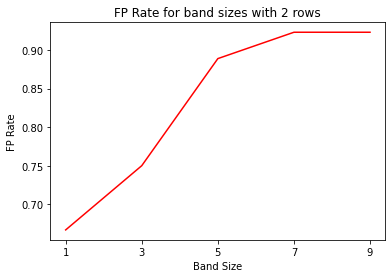

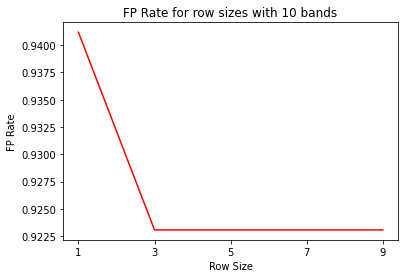

In [14]:
t = 0.8
r = 2
b = 10
iters = 10

# size of row/band configurations
sizes = [1, 3, 5, 7, 9]
pairs = len(sizes)

# avg fp vector for bands and row sizes
fpB = np.zeros(pairs)
fpR = np.zeros(pairs)

def iterPairs(band, row):
    
    # build signature matrix with n rows and 1000 cols
    n = band * row
    
    sigMat = buildSig(n_rows=n)
    
    # find articles similair to the first
    S = lsh(sigMat, 0, bands=band, rows=row)
    
    # compute fp rate with similair articles
    fp = fpRate(t, S)
    return fp

def plotFPRate(x, y, title, xtitle):
    plt.figure()
    plt.plot(x, y, c='r')
    plt.title(title)
    plt.xticks(x)
    plt.xlabel(f'{xtitle} Size')
    plt.ylabel('FP Rate')
    #plt.savefig(f'./plots/{xtitle}_config.png')
    
    
# realize fp rate for 10 different signature matrices
for i in range(iters):
    fpB += np.array(list(map(iterPairs, sizes, [r] * pairs)))
    fpR += np.array(list(map(iterPairs, [b] * pairs, sizes)))
    
fpB = fpB / iters
fpR = fpR / iters

plotFPRate(sizes, fpB, 'FP Rate for band sizes with 2 rows', 'Band')
plotFPRate(sizes, fpR, 'FP Rate for row sizes with 10 bands', 'Row')

In [9]:
import time
import heapq

def topN(n, sigMat):

    heap = []

    for i in range(n_articles):
        maxJS = 0.
        simCol = i
        for j in range(n_articles):
            if j == i:
                continue
            sim = np.sum(sigMat[:, i] == sigMat[:, j]) / n_hash
            if sim > maxJS:
                maxJS = sim
                simCol = j
                
        heapq.heappush(heap, (-maxJS, i, simCol))
        
    return(heapq.nsmallest(n, heap))


def topNLSH(n, sigMat, bands, rows):

    heap = []

    for i in range(n_articles):
        S = lsh(sigMat, i, bands=bands, rows=rows)
        maxJS = 0
        for j in S:
            js = jSim(i, j)
            if js > maxJS:
                maxJS = js
                simCol = j
                
        heapq.heappush(heap, (-maxJS, i, simCol))
        
    return(heapq.nsmallest(n, heap))

def reportTopN(topN):
    for js, id1, id2 in topN:
        a1 = getId(id1)
        a2 = getId(id2)
        print(f'{-js:.2f} JS - {a1}, {a2}')

In [12]:
# build default signature matrix
sigMat = buildSig()

t1 = time.perf_counter()
top5 = topN(5, sigMat)
t2 = time.perf_counter()

print(f'Top 5 query took {t2-t1:0.4f} sec')
print('5 most similair articles:')

reportTopN(top5)

Top 5 query took 6.6414 sec
5 most similair articles:
1.00 JS - t120, t7998
1.00 JS - t980, t2023
1.00 JS - t1088, t5015
1.00 JS - t1297, t4638
1.00 JS - t1768, t5248


In [13]:
# 5 most similar article pairs using LHS
b = 10
r = 9

sigMat = buildSig(b*r)

t1 = time.perf_counter()
top5 = topNLSH(5, sigMat, b, r)
t2 = time.perf_counter()

print(f'Top 5 query took {t2-t1:0.4f} sec')
print('5 most similair articles:')

reportTopN(top5)

Top 5 query took 34.5737 sec
5 most similair articles:
1.00 JS - t120, t7998
1.00 JS - t2957, t7111
1.00 JS - t7111, t2957
1.00 JS - t7998, t120
0.98 JS - t1297, t4638
